In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import imageio
import scipy as sp

from torchvision import transforms

import torch
from mpl_toolkits import mplot3d

from scipy.optimize import curve_fit
from PIL import Image

from scipy.special import softmax
import imageio
#np.set_printoptions(precision=1)
%matplotlib notebook
#plt.close('all')
import networkx as nx
from sklearn.decomposition import PCA
import torch.nn as nn  
import os


import networkx as nx
from mpl_toolkits.mplot3d import Axes3D

In [20]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Define the CNN backbone (shared for both inputs)
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 16, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2)
        )

        # Fully connected layer for similarity
        self.fc = nn.Sequential(
            nn.Linear(144, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 64)
           # Binary classification: Similar (1) or Not Similar (0)
        )

    def forward_one(self, x):
        # Forward pass for one input
        x = self.backbone(x)
        
        x = x.view(x.size()[0], -1)
        #print('x',x.size())
        x=self.fc(x) # Flatten
        return x

    def forward(self, input1, input2):
        # Forward pass for both inputs
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        
        #print('out1',output1.size())
        
        # Compute the cosine similarity between the two embeddings.
        cos_sim = cosine_similarity(output1, output2, dim=1, eps=1e-6)
        cos_sim = cos_sim.unsqueeze(1)  # Add an extra dimension to match the shape required for the fc layer.
        #print('cos_sim',cos_sim,cos_sim.size())
        # Similarity prediction
        #similarity = self.fc(cos_sim)
        prob_sim = torch.sigmoid(cos_sim)
        return prob_sim

    def get_embedding(self, x):
        # Method to get the embedding of a single image
        return self.forward_one(x)


def make_nodefeature(x,y,r,t):
    A=np.zeros((len(x),2))
       
    
    



def make_adjacency(x,y,r,t,ide,split_id,run,path='.'):
    A=np.zeros((len(x),len(x)))
    x_id = []
    t_id = []
    xp_id = []
    yp_id = []
    for i in range(len(x)):
        x_id.append(i+1)
        t_id.append(t[i])
        xp_id.append(x[i])
        yp_id.append(y[i])
        for j in range(len(x)):
            if ide[i]==ide[j] and ide[i]!=-2:
                if t[i]+1==t[j]: #or t[i]-1==t[j]:
                    A[i,j]=1
                    #if t[i]==6 and ide[i]==2:
                    #    print('t==6.0',i,j)
            elif ide[i]==split_id[j]:
                if ide[i]==-1:
                    A[i,j]=1
                elif t[i]+1==t[j] or t[i]-1==t[j]:
                    A[i,j]=1
              
    
    
    np.savetxt(path+'/'+str(run)+'_GT'+'/TRA/'+'A.txt', A,fmt='%i')
    np.savetxt(path+'/'+str(run)+'/'+'timetable.txt',np.c_[x_id,t_id,xp_id,yp_id], fmt=['%i', '%i', '%.2f', '%.2f'],delimiter='\t')
    
    return A
        

    
def make_weighted_adj_estimate(x,y,t,run,path='.'):
    
    #emb without void node
    
    x=x[1:]
    y=y[1:]
    t=t[1:]
    
    #############
    
    A=np.zeros((len(x),len(x)))
    
    for i in range(len(x)):
        #A[i,0]=1.5
        for j in range(len(x)):
            if t[i]+1==t[j]: #t[i]+1==t[j] or
                z,N=gaus2d(x[j], y[j], x[i], y[i])
                A[i,j]= z #1/((x[i]-x[j])**2+(y[i]-y[j])**2
        #A[i,0]=(1.5/np.sum(A[i,:]))*0.5*N #change here
        #print(A[i,:],i)
       
    A=A.round(decimals=2)
    np.fill_diagonal(A, 0.1)
    np.savetxt(path+'/'+str(run)+'/'+'B.txt', A)
    return A
    
    
def make_dist_matrix(x,y,t,run,path='.'):
    A=np.zeros((len(x),len(x)))
    
    for i in range(len(x)):
        for j in range(len(x)):
            if t[i]+1==t[j]: #t[i]+1==t[j] or
                A[i,j]=np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
       
    
    
    np.savetxt(path+'/'+str(run)+'/'+'D.txt', A)
    return A


def make_weighted_edgelist(A,run,path='.'):
    
    e1=[]
    e2=[]
    w=[]
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j and j!=0:
                A[i,j]=0
            
            if A[i,j]!=0:
                e1.append(int(i+1))
                e2.append(int(j+1))
                w.append(A[i,j]*100)
    #path+'/'+str(run)+'/'+'D.txt'
    
    np.savetxt(path+'/'+str(run)+'/'+'B.edgelist', np.c_[e1,e2,w], fmt='%i',delimiter='\t')
    return A,e1,e2,w



def make_true_edgelist(A,run,path='.'):
    
    e1=[]
    e2=[]
    w=[]
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j:
                A[i,j]=0
            
            if A[i,j]!=0:
                e1.append(int(i+1))
                e2.append(int(j+1))
                #w.append(A[i,j])
    
    
    np.savetxt(path+'/'+str(run)+'_GT'+'/TRA/'+'A.edgelist', np.c_[e1,e2], fmt='%i',delimiter='\t')
    return 0


def mean_normal(x):
    s=np.sum(x)
    return x #x/s


def gaus2d(x, y, mx, my, sx=0.07, sy=0.07):
    
    #idea: HWHM =  2ln⁡22ln2 = mean_dist/2 -> calc sig. 
    z=(1. / (2. * np.pi * sx * sy)) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))
    
    #if z < 0.01:
    #    z=0.01
    
    
    
    return z,(1. / (2. * np.pi * sx * sy))

'''

def padding(maxlen,run,path='.'):
    #A,B,E
    
    B=np.loadtxt(path+'/'+str(run)+'/'+'B.txt')
    A=np.loadtxt(path+'/'+str(run)+'_GT'+'/TRA/'+'A.txt')
    E=np.loadtxt(path+'/'+str(run)+'/'+'embed.txt')
    
    
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j:
                A[i,j]=0
                B[i,j]=0
                
    np.savetxt('./'+str(run)+'_GT'+'/'+'A_padded.txt', A,fmt='%i')
    #A=np.zeros((4,4))
    #B=np.zeros((4,4))
    
   #E=np.ones((4,6))
    
    h=np.ones(maxlen)*-1
    v=np.ones(len(A[0]))*-1
    
    #
    cur_E=len(E)
    cur_A=len(A)
    cur_Ah=len(A[0])
    zero_line=np.zeros(len(E[0]))
    for i in range(maxlen-cur_E):
        E=np.vstack([E, zero_line])
        
    for j in range(maxlen-cur_A):
        A=np.vstack([A, v])
        B=np.vstack([B, v])
        
    for z in range(maxlen-cur_Ah):
        A=np.column_stack([A, h])
        B=np.column_stack([B, h])
        
    #np.savetxt('./'+str(run)+'_GT'+'/'+'A_padded.txt', A,fmt='%i')
    np.savetxt('./'+str(run)+'/'+'B_padded.txt', B)
    np.savetxt('./'+str(run)+'/'+'embed_padded.txt',E)
    print(A.shape)   
    return A,B,E    
  '''  
#x = np.linspace(-5, 5)
#y = np.linspace(-5, 5)
#x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
#z = gaus2d(x, y)

#def correct(A,B,E,max_len,run):



#def A_B_dense(A,B):

def fit_func(x,a,b):
    return a*x+b

def fingerprint_emb(pos_x,pos_y,window,t,run,void_node=True,a_x=113.89266922,b_x=19.51478307,a_y=-114.14194117,b_y=131.3404747):
    x_l,x_r,y_l,y_u=calibrate_pix_pos(pos_x,pos_y,a_x,b_x,a_y,b_y,window)
    im = blend(run,t)#Image.open(path).convert('L') # Can be many different formats.
    im_crop = im.crop((x_l, y_l, x_r, y_u))
     
    if t==9 and run==95:
        im_crop.show()
    foo = im_crop.resize((10,10),Image.ANTIALIAS)

    imarray = np.asarray(foo)
    imarray=imarray.flatten()/255
    return imarray



def fingerprint_wrap(window,run,void=False):
    pos_x,pos_y,t= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t',usecols=(0,1,6), unpack=True)
    l=len(pos_x)-1
    
    
    f_e = np.array([np.zeros(100)])


    for k in range(int(np.max(t))+1):
        path='/home/mo/Desktop/IWR/TimeGraph2.0/'+str(run)+'/'+str(k)+'.png'
        pos_x_n=pos_x[t==k]
        pos_y_n=pos_y[t==k]
        if k==0:
            pos_x_n=pos_x_n[1:]
            pos_y_n=pos_y_n[1:]
        for j in range(len(pos_x_n)):
            imarray=norm_im_array(np.array([fingerprint_emb(pos_x_n[j],pos_y_n[j],window,k,run)]),offset=8.745098039215686292e-01)
            f_e=np.concatenate((f_e, imarray), axis=0)
            
    
    if void==False:
        f_e=f_e[1:]
            
        
    return f_e
    
    
def blend(run,t,path0='.'):
    
    
    
    pathm1=path0+'/'+str(run)+'/'+str(t-1)+'.png'
    path=path0+'/'+str(run)+'/'+str(t)+'.png'
    pathp1=path0+'/'+str(run)+'/'+str(t+1)+'.png'
    
    
    im = Image.open(path).convert('L')
    shape = np.asarray(im).shape
    
    #print(pixels.shape)
    try:
        imm1 = Image.open(pathm1).convert('L')
        pixels = np.asarray(imm1)
        #print(pixels)
        pixels = pixels.astype('float32')
        pixels = pixels/2
        #pixels = pixels.astype('int')
        imm1 = Image.fromarray(pixels).convert('L')
    except:
        pix=255*np.ones(shape)
        pix = pix.astype('float32')
        pix = pix/2
        imm1 = Image.fromarray(pix).convert('L')
        
    try:
        imp1 = Image.open(pathp1).convert('L')
    except:
        pix=255*np.ones(shape)
        imp1 = Image.fromarray(pix).convert('L')
    
    
    
    im3 = Image.blend(imm1, imp1, 0.5)
    im4 = Image.blend(im3, im, 0.5)
    #im4.show()
    return im4
    
    

def norm_im_array(arr,offset):
    return (arr-offset)*10
    
    
    
'''
pos_x=[5.926355409057428858e-01,4.604170197372819962e-01,6.250962551422760416e-02,1.223613241454796496e-01,6.376507269405902179e-01,1.103583087228645621e-01,4.233227679149828004e-01]
pos_y=[5.378065857159227692e-01,5.482527480620434934e-01,1.628245440499290486e-01,8.255699686855265673e-01,5.184511465256566032e-01,1.492480151352687523e-01,5.115442664966730613e-01]
pix_x=[87,72,27,33,92,32,68]
pix_y=[70,69,113,37,72,114,73]


plt.errorbar(pos_y, pix_y,fmt='.')   

popt, pcov = curve_fit(fit_func, pos_y,pix_y)

plt.plot(pos_y, fit_func(np.array(pos_y),*popt))
print(popt)
'''

a_y=-114.14194117
a_x=113.89266922
b_y=131.3404747
b_x=19.51478307
    
def calibrate_pix_pos(pos_x,pos_y,a_x,b_x,a_y,b_y,window):
    pix_x0 = pos_x* 512
    pix_y0 = (1-pos_y) * 512
    #print(pix_x0,pix_y0,int(pix_x0-window))
    return int(pix_x0-window),int(pix_x0+window),int(pix_y0-window),int(pix_y0+window)

def spectral_embedding(d,path=None):
    #B=symmetrize_matrix(B)
    
    #D=np.zeros(B.shape)
    
    #column_sums = np.sum(B, axis=0)
    #np.fill_diagonal(D, column_sums)
    
    #L = D-B
    
    #X = k_eigenvectors(L, d)
    
    #X=2*np.random.rand(X.shape[0],X.shape[1])-1
    #X=np.random.rand(X.shape[0],X.shape[1])
    X=RAPID_3(path,p_len=5,num_p=15,d=d)
    
    return X


def symmetrize_matrix(matrix):
    row, col = matrix.shape
    for i in range(row):
        for j in range(i, col):
            matrix[j][i] = matrix[i][j]
    return matrix    
    
    
def k_eigenvectors(matrix, k):
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    eigenvectors = eigenvectors[:, np.argsort(eigenvalues)[::-1]]
    return eigenvectors[:, :k]    
    

    
def pos_enc(p,n):
    E=np.zeros((p,n))
    for k in range(int(p/2)):
        for i in range(n):
            E[2*k,i]=np.sin(2*i*np.exp(-(k*np.log(1000))/(p)))
            E[2*k+1,i]=np.cos(2*i*np.exp(-(k*np.log(1000))/(p)))
            
    return E
'''
def fingerprint_cnn(pos_x,pos_y,window,t,run,void_node=False,a_x=113.89266922,b_x=19.51478307,a_y=-114.14194117,b_y=131.3404747,path0='.'):
    
    if void_node:
        pos_x = 0.74
        pos_y = 0.8
        x_l,x_r,y_l,y_u=calibrate_pix_pos(pos_x,pos_y,a_x,b_x,a_y,b_y,window)
        
        path='/home/mo/Desktop/IWR/TimeGraph2.0/void.png'
        
        im = Image.open(path).convert('L')
        shape = np.asarray(im).shape
        
        im_crop = im.crop((x_l, y_l, x_r, y_u))

        if t==9 and run==95:
            im_crop.show()


        im_crop = im_crop.resize((20,20),Image.ANTIALIAS)
        
        imarray = np.asarray(im_crop)
        

        im_tens=torch.zeros(3, 20,20)


        convert_tensor = transforms.ToTensor()
        im_tens[1]=convert_tensor(imarray)
        im_tens[0]=convert_tensor(imarray)
        im_tens[2]=convert_tensor(imarray)
        
    
    else:
        
        x_l,x_r,y_l,y_u=calibrate_pix_pos(pos_x,pos_y,a_x,b_x,a_y,b_y,window)


        pathm1=path0+'/'+str(run)+'/'+str(t-1)+'.png'
        path=path0+'/'+str(run)+'/'+str(t)+'.png'
        pathp1=path0+'/'+str(run)+'/'+str(t+1)+'.png'


        im = Image.open(path).convert('L')
        shape = np.asarray(im).shape
        try:
            im_m = Image.open(pathm1).convert('L')
        except:
            pix=255*np.ones(shape)
            im_m = Image.fromarray(pix).convert('L')
        try:
            im_p = Image.open(pathp1).convert('L')
        except:
            pix=255*np.ones(shape)
            im_p = Image.fromarray(pix).convert('L')





        im_crop = im.crop((x_l, y_l, x_r, y_u))
        im_m_crop = im_m.crop((x_l, y_l, x_r, y_u))
        im_p_crop = im_p.crop((x_l, y_l, x_r, y_u))






        #if t==9 and run==95:
        #    im_crop.show()


        im_crop = im_crop.resize((20,20),Image.ANTIALIAS)
        im_m_crop = im_m_crop.resize((20,20),Image.ANTIALIAS)
        im_p_crop = im_p_crop.resize((20,20),Image.ANTIALIAS)

        imarray = np.asarray(im_crop)
        #print('shape',imarray.shape)
        im_m_array = np.asarray(im_m_crop)
        im_p_array = np.asarray(im_p_crop)


        im_tens=torch.zeros(3, 20,20)


        convert_tensor = transforms.ToTensor()
        im_tens[1]=convert_tensor(imarray)
        im_tens[0]=convert_tensor(im_m_array)
        im_tens[2]=convert_tensor(im_p_array)

    return im_tens
'''
def fingerprint_cnn(pos_x,pos_y,window,t,run,void_node=False,a_x=113.89266922,b_x=19.51478307,a_y=-114.14194117,b_y=131.3404747,path0='.'):
    v_flag=False
    if pos_x==2:
        print('void')
        #pos_x = 0.5
        #pos_y = 0.5
        
        


        pathm1=path0+'void.png'
        path=path0+'void.png'
        pathp1=path0+'void.png'
        v_flag=True
        
    else:
        pathm1=path0+str(int(run))+'/'+str(int(t-1))+'.png'
        path=path0+str(int(run))+'/'+str(int(t))+'.png'
        pathp1=path0+str(int(run))+'/'+str(int(t+1))+'.png'


    x_l,x_r,y_l,y_u=calibrate_pix_pos(pos_x,pos_y,a_x,b_x,a_y,b_y,window)


       


    im = Image.open(path).convert('L')
    shape = np.asarray(im).shape
    try:
        im_m = Image.open(pathm1).convert('L')
    except:
        pix=255*np.ones(shape)
        im_m = Image.fromarray(pix).convert('L')
    try:
        im_p = Image.open(pathp1).convert('L')
    except:
        pix=255*np.ones(shape)
        im_p = Image.fromarray(pix).convert('L')




    if v_flag:
        im_crop = im
        im_m_crop = im_m
        im_p_crop = im_p
    else:
        im_crop = im.crop((x_l, y_l, x_r, y_u))
        im_m_crop = im_m.crop((x_l, y_l, x_r, y_u))
        im_p_crop = im_p.crop((x_l, y_l, x_r, y_u))






    #if t==9 and run==95:
    #    im_crop.show()


    im_crop = im_crop.resize((20,20),Image.ANTIALIAS)
    im_m_crop = im_m_crop.resize((20,20),Image.ANTIALIAS)
    im_p_crop = im_p_crop.resize((20,20),Image.ANTIALIAS)

    imarray = np.asarray(im_crop)
    #print('shape',imarray.shape)
    im_m_array = np.asarray(im_m_crop)
    im_p_array = np.asarray(im_p_crop)


    im_tens=torch.zeros(3, 20,20)


    convert_tensor = transforms.ToTensor()
    im_tens[1]=convert_tensor(imarray)
    im_tens[0]=convert_tensor(im_m_array)
    im_tens[2]=convert_tensor(im_p_array)
    
    #if v_flag:
    #    plt.imshow(im_tens.numpy().transpose(1, 2, 0))

    return im_tens
def fingerprint_cnn_wrap(window,run,void=False,path0='.'):
    pos_x,pos_y,t= np.loadtxt(path0+'/'+str(run)+'_GT'+'/TRA/'+'pos_GT.txt',skiprows=1, delimiter='\t',usecols=(0,1,6), unpack=True)
    
    
    model = SiameseNetwork()

    # Load the saved state dict into the model
    model.load_state_dict(torch.load('Siam_cell_new.pt'))
    model.eval()
    
    all_embeddings=[]


    for k in range(int(np.max(t))+1):
        path=path0+'/'+str(run)+'/'+str(k)+'.png'
        pos_x_n=pos_x[t==k]
        pos_y_n=pos_y[t==k]
        tensor_list =[]
        #if k==0:
            #pos_x_n=pos_x_n[1:]
            #pos_y_n=pos_y_n[1:]
        for j in range(len(pos_x_n)):
            im_tens=fingerprint_cnn(pos_x_n[j],pos_y_n[j],window,k,run,path0=path0)
            with torch.no_grad():  # ensures no gradient computation for speed and memory efficiency
                im_emb = model.get_embedding(im_tens.unsqueeze(0)).squeeze(0) 
                #print('im_emb', im_emb.shape)
            
            tensor_list.append(im_emb)
            
            
        time_frame_embeddings = torch.stack(tensor_list)
        #print('time_frame_embeddings',time_frame_embeddings.shape)
        all_embeddings.append(time_frame_embeddings)
        
    fin = torch.cat(all_embeddings, dim=0)
    return fin

        

def add_dicts(dict1,dict2):

    for key in dict2:
        if key in dict1:
            dict1[key] += dict2[key]
        else:
            dict1[key] = dict2[key]
            
    return dict1

        
        
def edge_list_conv(path):
    edge_list = []
    max_n = [1]

    with open(path, 'r') as f:
        for line in f:
            parts = line.split()
            edge_list.append((int(parts[0]), int(parts[1]), int(parts[2])))
            #edge_list.append((int(parts[1]), int(parts[0]), int(parts[2])))
            max_n.append(int(parts[1]))
    #print(max_n)
    num_nodes=np.max(max_n)
    return edge_list,num_nodes

def RAPID(path_start,p_len,num_p,iters,d=50):
    # Create a weighted graph
    #d=50
    #p_len=10
    G = nx.Graph()
    #path_start='/home/mo/Desktop/IWR/TimeGraph2.0/node2vec/graph/7.edgelist'
    edge_list,num_nodes=edge_list_conv(path_start)
    
    G.add_weighted_edges_from(edge_list)
    
    #f_mat=np.random.rand(num_nodes, d)
    
    #f_res=np.random.rand(num_nodes, d)
    f_res= np.random.uniform(-1, 1, size=(num_nodes,d))
    for g in range(iters):
        f_mat=f_res
        for j in range(1,num_nodes+1):
            #f_mat=f_res
            count_tot = {}
            for k in range(num_p):


                # Perform a random walk with restart from node 1
                start_node = j
                current_node = start_node
                path = [current_node]

                for i in range(p_len):
                    #print('c',current_node)
                    # Compute the probabilities of moving to neighboring nodes
                    #probs = np.zeros(len(G.nodes))
                    probs=[]
                    for neighbor in G.neighbors(current_node):
                        #print(neighbor)
                        #probs[neighbor-1] = G[current_node][neighbor]['weight']
                        probs.append(G[current_node][neighbor]['weight'])

                    # Normalize the probabilities
                    probs /= np.sum(probs)

                    #print(probs)

                    # Choose the next node to visit based on the probabilities
                    current_node = np.random.choice(list(G.neighbors(current_node)), p=probs)

                    # Add the node to the path
                    path.append(current_node)

                #print(path)
                counts = {}

                for item in path:
                    if item in counts:
                        counts[item] += 1
                    else:
                        counts[item] = 1
                add_dicts(count_tot,counts)
                #print('tot',j,k,count_tot)


            arrays = [value * f_mat[key-1] for key, value in count_tot.items()]
            #print(arrays)
            # sum up the arrays to get the resulting array
            result = np.sum(arrays, axis=0)
            f_res[j-1]=result/(num_p*p_len)
        
    return f_res


def RAPID_2(path_start,p_len,num_p,d=50):
    # Create a weighted graph
    #d=50
    #p_len=10
    G = nx.Graph()
    #path_start='/home/mo/Desktop/IWR/TimeGraph2.0/node2vec/graph/7.edgelist'
    edge_list,num_nodes=edge_list_conv(path_start)
    
    G.add_weighted_edges_from(edge_list)
    
    #f_mat=np.random.rand(num_nodes, d)
    
    f_res=np.zeros((num_nodes, num_nodes))
    #f_res= np.random.uniform(-1, 1, size=(num_nodes,d))
    
    for j in range(1,num_nodes+1):
        
        #f_mat=f_res
        count_tot = {}
        for k in range(num_p):


            # Perform a random walk with restart from node 1
            start_node = j
            current_node = start_node
            path = [current_node]

            for i in range(p_len):
                #print('c',current_node)
                # Compute the probabilities of moving to neighboring nodes
                #probs = np.zeros(len(G.nodes))
                probs=[]
                for neighbor in G.neighbors(current_node):
                    #print(neighbor)
                    #probs[neighbor-1] = G[current_node][neighbor]['weight']
                    probs.append(G[current_node][neighbor]['weight'])

                # Normalize the probabilities
                probs /= np.sum(probs)

                #print(probs)

                # Choose the next node to visit based on the probabilities
                current_node = np.random.choice(list(G.neighbors(current_node)), p=probs)

                # Add the node to the path
                path.append(current_node)

            #print(path)
            counts = {}

            for item in path:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1
            add_dicts(count_tot,counts)
            #print('tot',j,k,count_tot)
        #print(j)
        #print('tot',count_tot)
        #arrays = [value * f_mat[key-1] for key, value in count_tot.items()]
        #print(arrays)
        # sum up the arrays to get the resulting array
        #result = np.sum(arrays, axis=0)
        for key, value in count_tot.items():
            f_res[j-1,key-1]=value
    pca = PCA(n_components=d)
    f_fin=pca.fit_transform(f_res)
    norms = np.linalg.norm(f_fin, axis=1, keepdims=True)
    f_fin = f_fin / norms
    return f_fin


def RAPID_3(path_start,p_len,num_p,d=50):
    # Create a weighted graph
    timetable_path = path_start.replace('B.edgelist', 'timetable.txt')
    G = nx.Graph()

    #path_start='/home/mo/Desktop/IWR/TimeGraph2.0/node2vec/graph/7.edgelist'
    edge_list,num_nodes=edge_list_conv(path_start)
    
    G.add_weighted_edges_from(edge_list)
    
    #f_mat=np.random.rand(num_nodes, d)
    
    f_res=np.zeros((num_nodes, d))
    #f_res= np.random.uniform(-1, 1, size=(num_nodes,d))
    # List to store all random walk paths
    for j in range(1,num_nodes+1):
        
        #f_mat=f_res
        all_paths = []
        for k in range(num_p):


            # Perform a random walk with restart from node 1
            start_node = j
            current_node = start_node
            path = [current_node]

            for i in range(p_len):
                #print('c',current_node)
                # Compute the probabilities of moving to neighboring nodes
                #probs = np.zeros(len(G.nodes))
                probs=[]
                for neighbor in G.neighbors(current_node):
                    #print(neighbor)
                    #probs[neighbor-1] = G[current_node][neighbor]['weight']
                    probs.append(G[current_node][neighbor]['weight'])

                # Normalize the probabilities
                probs /= np.sum(probs)

                #print(probs)

                # Choose the next node to visit based on the probabilities
                current_node = np.random.choice(list(G.neighbors(current_node)), p=probs)

                # Add the node to the path
                path.append(current_node)
                
            all_paths.append(path)
            
        f_res[j-1]=compute_aggregated_embedding(all_paths, timetable_path)
    return f_res
def modify_matrix(matrix):
    # Check for rows with all zeros and set the first element to 1
    row_sums = np.sum(matrix, axis=1)
    matrix[row_sums == 0, 0] = 1

    # Check for columns with all zeros and set the first element to 1
    col_sums = np.sum(matrix, axis=0)
    matrix[0, col_sums == 0] = 1

    return matrix
#(Random-wAlk-based Path-feature calculatIon on Weighted graphs)

def randomly_delete_rows(file_path, p):
    # Load the data
    x, y, r, ide, split_id, split_prob, t = np.loadtxt(file_path, skiprows=1, delimiter='\t', usecols=(0, 1, 2, 3, 4, 5, 6), unpack=True)

    # Combine the columns into a 2D array
    data = np.column_stack((x, y, r, ide, split_id, split_prob, t))
    
    # Create a mask to decide which rows to keep
    # Always keep rows where t==0, and otherwise decide randomly based on probability p
    mask = np.logical_or(t == 0, np.random.rand(data.shape[0]) > p)
    
    # Apply the mask to filter the data
    filtered_data = data[mask]

    # Save the resulting data back to the file
    with open(file_path, 'w') as f:
        # Write the header
        f.write("# x\ty\tr\tid\tsplit_id\ts_prob\tt\n")
        # Write the data
        np.savetxt(f, filtered_data, delimiter='\t', fmt='%f')
        
def compute_aggregated_embedding(all_random_walks, timetable_path):
    aggregated_histogram = np.zeros(64)
    for path in all_random_walks:
        embedding = compute_embedding(path, timetable_path)
        aggregated_histogram += embedding

    # Normalize the aggregated histogram
    aggregated_histogram /= np.sum(aggregated_histogram)

    return aggregated_histogram


def compute_embedding(path, timetable_path):
    # Load timetable data
    timetable_data = np.loadtxt(timetable_path)
    
    # Create a dictionary mapping node ids to their x, y coordinates
    node_to_coords = {int(row[0]): (row[2], row[3]) for row in timetable_data}
    
    # For each node in path, fetch its x, y coordinates and update histogram
    histogram = np.zeros(64)
    for node in path:
        # Adjust for the offset between B.edgelist and timetable.txt
        adjusted_node = node + 1
        
        x, y = node_to_coords[adjusted_node]
      
        cell_index = get_cell_index(x, y)
        #print(timetable_path,adjusted_node,x,y,cell_index)
        histogram[cell_index] += 1

    # Normalize the histogram
    histogram /= np.sum(histogram)

    return histogram
def get_cell_index(x, y):
    """
    Given x, y coordinates in the range [0, 1], determine which of the 8x8 cells it falls into.
    Returns a flattened index in the range [0, 63].
    """
    i = min(int(x * 8), 7)  # Ensure that the value does not exceed 7
    j = min(int(y * 8), 7)  # Ensure that the value does not exceed 7
    return i * 8 + j


1.0
[0.4765458  0.87914965]


<IPython.core.display.Javascript object>


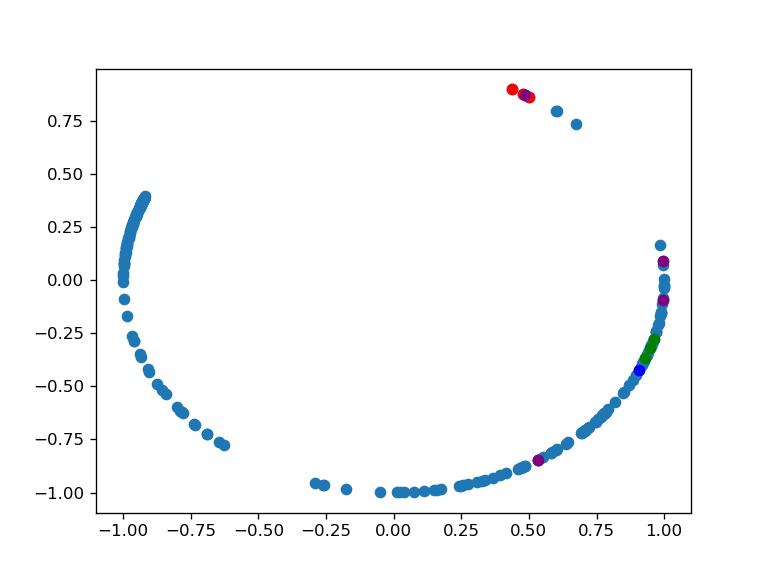

In [21]:
'''
import numpy as np

two iteration?
1st weights 
2nd similarity as weight?


'''
#print(stop)
d=2
p_len=45
iters=1
path_start='/home/mo/Desktop/IWR/TimeGraph2.0/node2vec/graph/7.edgelist'
num_p=15
f_res=RAPID_2(path_start,p_len,num_p,d)

print(np.linalg.norm(f_res[0]))
print(f_res[3])

plt.scatter(f_res[:, 0], f_res[:, 1])

plt.scatter(f_res[0, 0], f_res[0, 1],c='red')

plt.scatter(f_res[3, 0], f_res[3, 1],c='red')
plt.scatter(f_res[7, 0], f_res[7, 1],c='red')


plt.scatter(f_res[1, 0], f_res[1, 1],c='green')

plt.scatter(f_res[5, 0], f_res[5, 1],c='green')
plt.scatter(f_res[8, 0], f_res[8, 1],c='green')


plt.scatter(f_res[14, 0], f_res[14, 1],c='blue')

plt.scatter(f_res[9, 0], f_res[9, 1],c='purple')
plt.scatter(f_res[10, 0], f_res[10, 1],c='purple')
plt.scatter(f_res[16, 0], f_res[16, 1],c='purple')
plt.scatter(f_res[78, 0], f_res[78, 1],c='purple')

In [19]:
A=np.loadtxt('./'+str(2)+'/'+'embed.txt')
print(A)

A=np.vstack([A, np.zeros(len(A[0]))])
#A=np.append(A,np.zeros(len(A[0])))
#print(A)


A=np.ones((3,4))
B=np.zeros((3,2))
print(np.c_[A, B])
print(gaus2d(1.8*0.07, 1.8*0.07, 0, 0, sx=0.07, sy=0.07))
C=np.zeros((3,3))
C[0,1]=0.3
C[0,2]=0.3
C[2,2]=0.7

print(C)
L=spectral_embedding(C,2)
print(L)
#print(k_eigenvectors(L, 2))

#A,B,E =padding(7,1)

#print(E)
#blend(10)

FileNotFoundError: ./2/embed.txt not found.

In [25]:
lenA=[]
path0='/media/mo/Label/HeLa_2_track_test/'#'/home/mo/Desktop/IWR/Cell_GT_Proj/HeLa_art'

for folder in os.listdir(path0):
    if folder.endswith("_GT"):
        run = int(folder.split('_')[0])
        #run=16 #!!!!!!!!!
        i=run
        
        #randomly_delete_rows(path0+'/'+str(run)+'_GT'+'/TRA/'+'pos_GT.txt', p=0.05)
        
        
        x,y,r,ide,split_id,split_prob,t= np.loadtxt(path0+'/'+str(run)+'_GT'+'/TRA/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2,3,4,5,6), unpack=True)
        #print(len(x))
        A=make_adjacency(x,y,r,t,ide,split_id,run,path=path0)
        #print(len(A),i)
        lenA.append(len(A))

        B=make_weighted_adj_estimate(x,y,t,run,path=path0)
        #print(B)
        C,e1,e2,w=make_weighted_edgelist(B,run,path=path0)




        path_start=path0+'/'+str(run)+'/'+'B.edgelist'
        s=spectral_embedding(path=path_start,d=64)
        s=np.concatenate((np.array([np.ones(len(s[0]))]), s), axis=0)
        print('s',s.shape)
        q=fingerprint_cnn_wrap(115,run,void=False,path0=path0)
        
        #pca = PCA(n_components=2)
        #q=pca.fit_transform(q)
        #norms = np.linalg.norm(q, axis=1, keepdims=True)
        #q = q / norms
        #plt.scatter(q[:, 0], q[:, 1])
        #plt.scatter(q[1, 0], q[1, 1],c='purple')
        ##plt.scatter(q[5, 0], q[5, 1],c='red')
        #plt.scatter(q[14, 0], q[14, 1],c='purple')
        #plt.scatter(q[27, 0], q[27, 1],c='purple')
        #print('q',q,q.shape)
        #s=np.concatenate((np.array([2*np.random.rand(len(s[0]))-1]), s), axis=0)

        q_np = q.numpy()  # Convert PyTorch tensor to numpy array
        com = np.concatenate((s, q_np), axis=1)
        np.savetxt(path0+'/'+str(run)+'/'+'embed.txt', com )

        make_true_edgelist(A,run,path=path0)

        make_dist_matrix(x,y,t,run,path=path0)
        #print(stop)
    
#maxlen=np.max(lenA)
#print(maxlen)






s (87, 64)
void


/tmp/ipykernel_124756/252022592.py:570: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im_crop = im_crop.resize((20,20),Image.ANTIALIAS)
/tmp/ipykernel_124756/252022592.py:571: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im_m_crop = im_m_crop.resize((20,20),Image.ANTIALIAS)
/tmp/ipykernel_124756/252022592.py:572: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im_p_crop = im_p_crop.resize((20,20),Image.ANTIALIAS)


s (138, 64)
void
s (89, 64)
void
s (83, 64)
void
s (135, 64)
void
s (272, 64)
void
s (292, 64)
void
s (326, 64)
void
s (246, 64)
void


In [ ]:
run=16
path0='/media/mo/Label/HeLa_2_track_test'


#A=A+np.eye(len(A), dtype=int)

for t in range(0,12):
    id,tt = np.loadtxt(path0+'/'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
    A=np.loadtxt(path0+'/'+str(run)+'_GT'+'/TRA/'+'A.txt')
    D=np.loadtxt(path0+'/'+str(run)+'/'+'D.txt')
    bg=A[0]
    for i in range(len(A)):
        for j in range(len(A)):
            if i>j:
                A[i,j]=0# np.random.randint(find_max_t(path0+'/'+str(run))) #!!!!!!!!how many t??
    id1 = id[tt==t].astype(int)
    if t==0:
        id1=id1[1:]
    id2 = id[tt==(t+1)].astype(int)





    A=A[id1-1]

    A=A[:,id2-1]


    D=D[id1-1]
    D=D[:,id2-1]





    #print(bg[id1-1])
    #print(bg[id2-1])


    A=np.concatenate((np.array([bg[id2-1]]), A), axis=0)

    bg_a=np.append(1,bg[id1-1])
    #print(bg_a)
    A=np.concatenate((np.array([bg_a]).T, A), axis=1)
    A=modify_matrix(A)
    print('t',t)
    print(A)

In [ ]:
#[22, 43, 54, 43, 54, 58]
#[22, 20, 9, 20, 22, 43]
#[22, 20, 9, 20, 32, 45]
#[22, 20, 22, 43, 22, 43]
#[22, 43, 54, 58, 54, 43]
#[22, 20, 22, 43, 22, 20]
#[22, 43, 54, 43, 22, 43]
#[22, 43, 54, 43, 22, 20]
#[22, 44, 30, 15, 30, 15]
random_walk=[]

# Read node positions
with open('/media/mo/Label/HeLa_2_track_test/6_GT/TRA/pos_GT.txt', 'r') as f:
    lines = f.readlines()[2:]  # Skip the first line
    positions = {}
    ids = []
    for index, line in enumerate(lines, start=1):  # Start enumerating from 1
        tokens = line.split()
        x = float(tokens[0])
        y = float(tokens[1])
        t = float(tokens[6])
        id = float(tokens[3])
        ids.append(id)
        positions[index] = (t, y, x)  # Store t as the first coordinate

unique_ids = list(set(ids))
colors = plt.cm.get_cmap('viridis', len(unique_ids))

# Initialize graph
G = nx.Graph()

# Read edges and add them to the graph
weights = []
with open('/media/mo/Label/HeLa_2_track_test/6/B.edgelist', 'r') as f:
    for line in f:
        tokens = line.split()
        node1 = int(tokens[0])  # Use line number as node id
        node2 = int(tokens[1])  # Use line number as node id
        weight = float(tokens[2])
        weight = (weight - 1) / (3247 - 1)
        weights.append(weight)
        G.add_edge(node1, node2, weight=weight)

# Normalize weights to be between 0 and 1

selected_ids=[7,3,2,6]

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

'''
# Add nodes
for index, (node, (t, y, x)) in enumerate(positions.items()):
    id = ids[index]
    
    #if id in selected_ids:
     #   color_index = unique_ids.index(id)
      #  co = colors(color_index)
      #  ax.scatter(t, y, x, s=20, c=co)
    color_index = unique_ids.index(id)
    co = colors(color_index)
    if id ==2:
        co='red'
    ax.scatter(t, y, x, s=20, c=co)
'''
for index, (node, (t, y, x)) in enumerate(positions.items()):
    id = ids[index]
    color_index = unique_ids.index(id)
    co = colors(color_index)
    if node in random_walk:  # Check if the node is in the random walk
        co = 'red'
    ax.scatter(t, y, x, s=20, c=co)
    
print(G.edges(data=True))
# Add edges with color and thickness corresponding to normalized weight
for index, (u, v, data) in enumerate(G.edges(data=True)):
    t0, y0, x0 = positions[u]
    t1, y1, x1 = positions[v]
    weight = data['weight']
    ax.plot([t0, t1], [y0, y1], [x0, x1], 'k-', lw=weight*2.5+0, alpha=weight * 0.8 + 0.2)

# Setting labels
ax.set_xlabel('T Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('X Label')

# Show the plot
plt.show()

In [ ]:
#print(stop)

for i in range(1,100):

    run=i

    b = np.loadtxt('./node2vec/emb/'+str(run)+'.emb',skiprows=1, delimiter=' ', unpack=True)
    

    ind=np.argsort(b[0])

    for l in range(len(b)):
        b[l]= np.take_along_axis(b[l], ind,axis=0)  
    b=np.transpose(b)
    b=b[:,1:]
    
    
    ####
    b=np.concatenate((np.array([np.zeros(len(b[0]))]), b), axis=0) #######if void node not included in n2v
    ####
    
    
    fingerprint_cnn_wrap(20,run,void=False)  #always 000000000000000 for fingerprint
    #b=np.c_[b, f_e]
    #print(len(f_e),run)
    
    #pos_x,pos_y= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t',, unpack=True)
    #id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
    #split_prob = pos.T[:,5]
    #split_prob = split_prob[:, np.newaxis]
    #r = pos.T[:,2]
    #r=r[:, np.newaxis]
    
    #print(b.shape,pos.shape)
    
    #b=np.append(b,r,axis=1)
    #b=np.append(b,split_prob,axis=1)
    
    #np.savetxt('./'+str(run)+'/'+'embed.txt', b)
    
    
    ##remove below if n2v is used
    
    print(len(b[0]),run)
    
    #p = np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', unpack=True)
    #split_prob = p.T[:,5]
    #print(len(split_prob),split_prob)
    #b = b.T[:,0:3]
    #split_prob=split_prob[:, np.newaxis]
    #print(len(b),b)
    
    #print(b.shape,split_prob.shape)
    
    #######b=np.append(b,split_prob,axis=1)
    
    #b=np.append(pos,split_prob,axis=1)
    
    
    #print(b)
    #b=np.repeat(b, 6, axis=1)
    #print(i)
    #print(b)
    
    
    
    #np.savetxt('./'+str(run)+'/'+'embed_n2v.txt', b)
    #padding(maxlen,run)
    

python ./src/main.py --input ./graph/14.edgelist --output ./emb/14.emb --dimensions 25 --walk-length 40 --num-walks 300 --window-size 30 --p 0.25 --q 4 --iter 20 --weighted

In [ ]:

#np.savetxt('./node2vec/emb/'+str(10)+'.emb',i)
x,y= np.loadtxt('./'+str(2)+'/'+'embed.txt',usecols=(0,1),unpack=True)
print(x,y)
#i=ide
#print(i)
#print(i[0])
plt.scatter(x,y,s=1)
#plt.scatter(x[1],y[1],c='r')
#plt.scatter(x[i==4],y[i==4],c='blue')
#plt.scatter(x[i==5],y[i==5],c='g')
#plt.scatter(x[i==6],y[i==6],c='black')
#plt.scatter(x[i==7],y[i==7],c='violet')
#plt.scatter(x[i==10],y[i==10],c='orange')
#plt.scatter(x[i==2],y[i==2],c='grey')

In [ ]:
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')

run=85

x,y,r,ide,split_id,split_prob,t= np.loadtxt('./'+str(run)+'_GT'+'/'+'pos_GT.txt',skiprows=1, delimiter='\t', usecols=(0,1,2,3,4,5,6), unpack=True)



x=x[1:]
y=y[1:]
t=t[1:]

id1,id2=np.loadtxt('./'+str(run)+'_GT'+'/'+'reconstruct.edgelist', delimiter='\t', usecols=(0,1), unpack=True)
#id1,id2=np.loadtxt('./'+str(run)+'_GT'+'/'+'A.edgelist', delimiter='\t', usecols=(0,1), unpack=True)
#id1,id2,w=np.loadtxt('./node2vec/graph/'+str(run)+'.edgelist', delimiter='\t', usecols=(0,1,2), unpack=True)
#print(len(id1))
id2=id2[id1!=1]
id1=id1[id1!=1]

#w=w/np.max(w)


xline=[]
yline=[]
tline=[]
for i in range(len(id1)):
    
    xline=[]
    yline=[]
    tline=[]
    
    print(id1[i],id2[i])
    xline.append(x[int(id1[i]-1)])   
    yline.append(y[int(id1[i]-1)])
    tline.append(t[int(id1[i]-1)])
    
    xline.append(x[int(id2[i]-1)])
    yline.append(y[int(id2[i]-1)])
    tline.append(t[int(id2[i]-1)])
    
    print(xline)
    
    #ax.plot3D(tline, yline, xline, c='red',alpha=w[i])
    ax.plot3D(tline, yline, xline, c='grey')


#zline = np.linspace(0, 15, 1000)
#xline = np.sin(zline)
#yline = np.cos(zline)
#

# Data for three-dimensional scattered points
zdata = x
xdata = t
ydata = y
ax.scatter3D(xdata, ydata, zdata);

#plt.savefig('./TimeGraph.png',dpi=my_dpi,transparent=False) 

In [ ]:
def colour_func(ii,prev_c,prev_id,id1,id2):
    id1=id1[id2==ii]
    #print(id1,id2)
    if len(id1)==0:
        print('ii',ii)
        print(prev_c)
        return prev_c[int(ii-2)],False
    if id1==1:
        return 'black',True
    else:
        #print(id1,prev_id,prev_c)
        print('prev_c',np.array(prev_c))
        c_cf=np.array(prev_c)[prev_id==id1[0]]
        print('c',c_cf)
    return c_cf[0],False
    


c=['blue','green','violet']

id,tt = np.loadtxt('./'+str(run)+'/'+'timetable.txt', delimiter='\t', usecols=(0,1), unpack=True)
id=id[1:]
tt=tt[1:]
id_f=[2,3,4]


print(c[id_f==1])


    


for t in range(31):
    
        
    
    my_dpi=96
    pix=150
    
    
    fig = plt.figure(figsize=(pix/my_dpi, pix/my_dpi), dpi=my_dpi)
    fig = plt.gcf()
    ax = fig.gca()
    
    print('c_full',c)
    prev_c=c
    prev_id=id_f
    
    c=[]
    id_f=[]
    
    for u in range(len(id[tt==t])):
        x_n=x[int(id[tt==t][u]-1)]  
        y_n=y[int(id[tt==t][u]-1)]
        r_n=r[int(id[tt==t][u]-1)]  
        c_cf,rec=colour_func(id[tt==t][u],prev_c,prev_id,id1,id2)
        c.append(c_cf)
        #print('c.app',c)
        id_f.append(id[tt==t][u])
        if rec:
            rec1=plt.Rectangle((x_n,y_n), r_n, r_n,fc=c_cf,ec=c_cf) 
            ax.add_patch(rec1)
        else:
            circ1=plt.Circle((x_n,y_n), r_n, color=c_cf)
            ax.add_patch(circ1)
        
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    plt.savefig('./'+str(run)+'_GT'+'/'+str(t)+'.png',dpi=my_dpi,transparent=False) 

In [ ]:
x_t=[]
for j in range(len(ide)):
    x_t=[]
    x_t.append(x[ide==j])
    print(str(j),x_t)